In [535]:
# import tables as tb
# dict_of_samples = {}
# dict_of_headers = {}
# with tb.open_file(c.joker_results_path, 'r') as f:
#     for apid in tqdm(meta['APOGEE_ID'][:1000]):
#         dict_of_samples[apid] = f.root[apid]['samples'].read()
#         dict_of_headers[apid] = at.meta.get_header_from_yaml(
#             h.decode('utf-8') for h in f.root[apid]['samples.__table_column_meta__'].read())

In [20]:
import os

import astropy.table as at
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm
import thejoker as tj
import tables as tb
from scipy.stats import beta
from scipy.special import loggamma, logsumexp

from hq.config import Config
from hq.data import get_rvdata

from helpers import ms_path, rg_path, fast_m2_min, fast_mf, load_samples

In [3]:
def beta_logpdf(x, a, b):
    denom = loggamma(a) + loggamma(b)
    res = loggamma(a+b) + (a-1)*np.log(x) + (b-1)*np.log(1-x) - denom
    return res.real

In [4]:
c = Config.from_run_name('dr16-random')

In [5]:
allstar, allvisit = c.load_alldata()

In [6]:
meta = at.QTable.read('../catalogs/dr16_gaia_starhorse_metadata.fits')
meta = at.Table(meta[np.isfinite(meta['mass'])], masked=False).filled()
# meta = at.join(meta, allstar, keys='APOGEE_ID')

INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]


In [7]:
X = np.stack((meta['TEFF'], meta['LOGG'])).T
ms_mask = ms_path.contains_points(X)
rg_mask = rg_path.contains_points(X)
ms_mask.sum(), rg_mask.sum()

(58418, 134475)

In [10]:
all_mask = (ms_mask & 
            (meta['TEFF'] > 4000) & (meta['TEFF'] < 7000) &
            (meta['M_H'] > -2) & (meta['M_H'] < 0.4))
all_mask.sum()

53790

In [12]:
(all_mask & meta['mcmc_success']).sum()

815

---

### TMP

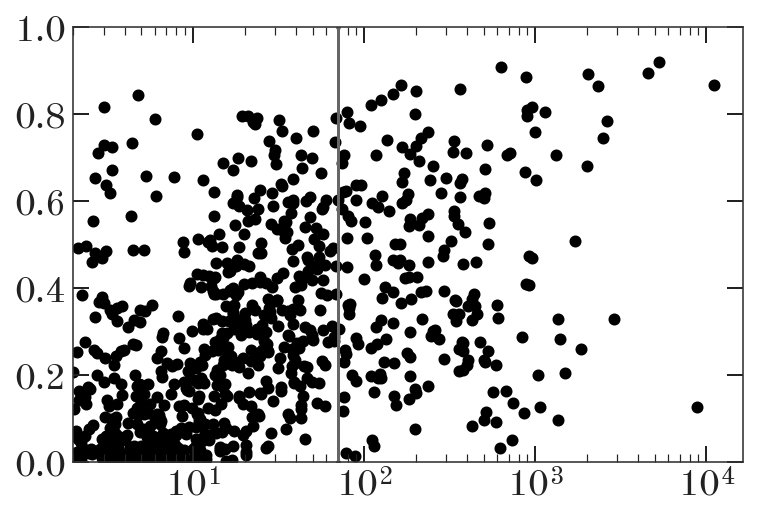

In [15]:
plt.scatter(meta['MAP_P'][(all_mask & meta['mcmc_success'])],
            meta['MAP_e'][(all_mask & meta['mcmc_success'])])
plt.xscale('log')
plt.xlim(2, 16384)
plt.ylim(0, 1)
plt.axvline(70.)

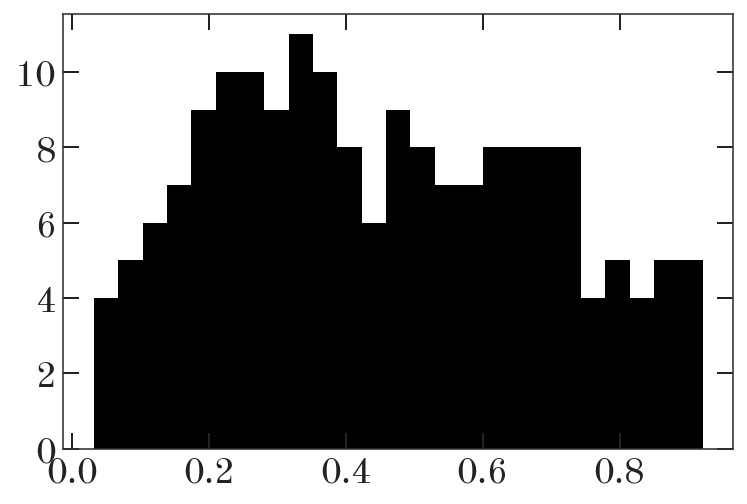

In [19]:
plt.hist(meta['MAP_e'][all_mask & meta['mcmc_success'] & (meta['MAP_P'] > 100)],
         bins=25);

In [22]:
all_samples = []
for row in meta[all_mask & meta['mcmc_success'] & (meta['MAP_P'] > 100)]:
    samples = load_samples(c, row)
    all_samples.append(samples)

(0, 1)

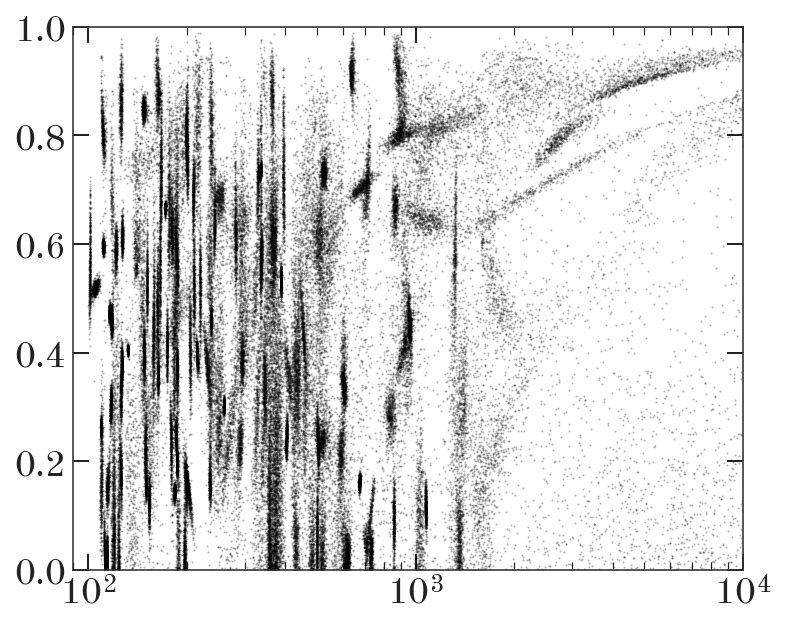

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for samples in all_samples:
    ax.plot(samples['P'].value, samples['e'],
            marker='o', mew=0, ms=1, 
            ls='none', alpha=0.3, color='k')
ax.set_xscale('log')
ax.set_xlim(90, 1e4)
ax.set_ylim(0, 1)

### TMP

---

4995

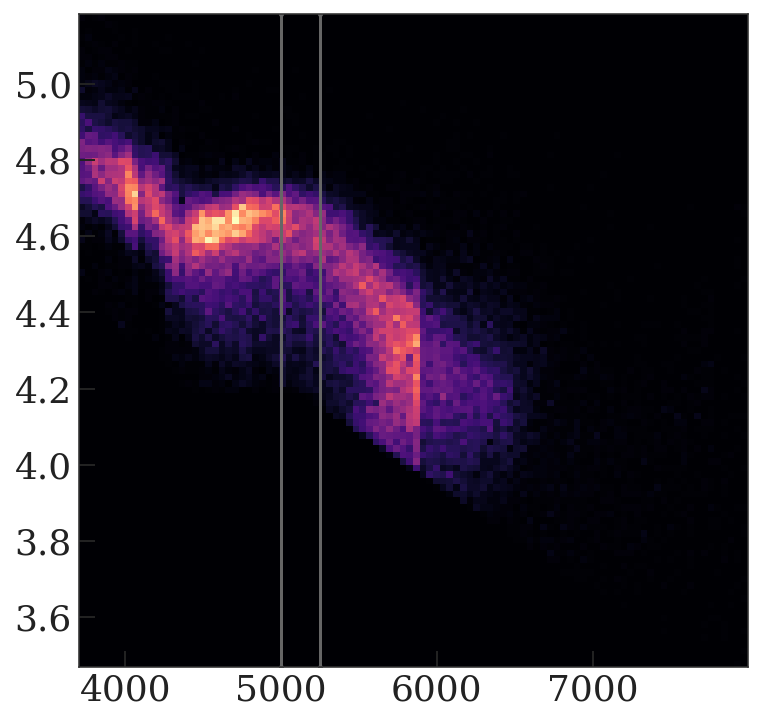

In [394]:
plt.hist2d(X[ms_mask, 0], X[ms_mask, 1], bins=(100, 100));
plt.axvline(5000)
plt.axvline(5250)

bin_mask = ms_mask & (meta['TEFF'] > 5000) & (meta['TEFF'] < 5250)
bin_mask.sum()

In [26]:
# meta_bin = meta[bin_mask]
meta_bin = meta[all_mask & meta['mcmc_success'] & (meta['MAP_P'] > 100)]
len(meta_bin)

181

In [27]:
samples_nk = at.Table()
samples_nk['APOGEE_ID'] = np.empty(len(meta_bin), 
                                   dtype='U{}'.format(len(meta['APOGEE_ID'][0])))

for name in ['P', 'e', 'K', 'm1', 'm2sini']:
    samples_nk[name] = np.full((len(meta_bin), c.requested_samples_per_star), np.nan)

In [30]:
for n, row in enumerate(tqdm(meta_bin)):
    samples_nk['APOGEE_ID'][n] = row['APOGEE_ID']
    
    samples = load_samples(c, row)
    _, idx = np.unique(samples['e'], return_index=True)
    samples = samples[idx]
    
    K_n = len(samples)
    m1s = np.random.normal(row['mass'], row['mass_err'], 
                           size=min(c.requested_samples_per_star, K_n))
    mfs = fast_mf(samples['P'], samples['K'], samples['e'])
    m2min = fast_m2_min(m1s, mfs.to_value(u.Msun))
    
    for name in ['P', 'e', 'K']:
        samples_nk[name][n, :K_n] = samples[name].value
    
    samples_nk['m1'][n, :K_n] = m1s[:K_n]
    samples_nk['m2sini'][n, :K_n] = m2min[:K_n]

In [34]:
P_min = 100
K_min = 1

In [35]:
e_nk = samples_nk['e'].copy()

# derp = np.repeat(((meta_bin['max_unmarginalized_ln_likelihood'] - meta_bin['robust_constant_ln_likelihood']) < 1)[:, None], 512, axis=1)
# skip_mask = ((samples_nk['K'] < K_min)  | (samples_nk['P'] < P_min) | derp)
skip_mask = (np.percentile(samples_nk['K'], 5, axis=1) < K_min)[:, None] | (samples_nk['P'] < P_min)
e_nk[skip_mask] = np.nan

ln_prior0 = beta_logpdf(e_nk, 0.867, 3.03)

K_n = np.isfinite(e_nk).sum(axis=1)

# Weights:
b_n = np.ones_like(e_nk)
b_n[~np.isfinite(e_nk)] = 0.

In [36]:
Kn_mask = K_n > 128
args = (e_nk[Kn_mask], K_n[Kn_mask], b_n[Kn_mask], ln_prior0[Kn_mask])
print(Kn_mask.sum())

158


In [37]:
def ln_prior(p):
    a, b = p
    
    if a <= 0 or b <= 0:
        return -np.inf
    
    return 0.


def ln_likelihood(p, e_nk, K_n, b_n, ln_prior0):
    a, b = p
    
    new_ln_prob = beta_logpdf(e_nk, a, b)
    ll = logsumexp(new_ln_prob - ln_prior0, b=b_n, axis=1) - np.log(K_n)
    return ll
    
    
def ln_prob(p, e_nk, K_n, b_n, ln_prior0):
    lp = ln_prior(p)
    if not np.isfinite(lp):
        return -np.inf
    
    ll = ln_likelihood(p, e_nk, K_n, b_n, ln_prior0).sum()
    if not np.isfinite(ll):
        return -np.inf
    
    return lp + ll

In [42]:
_ngrid = 64
a_b_grid = map(np.ravel, np.meshgrid(np.linspace(0.1, 5, _ngrid),
                                     np.linspace(0.1, 5, _ngrid)))
a_b_grid = np.stack(list(a_b_grid)).T
a_b_grid.shape

(4096, 2)

In [43]:
ll_grid = np.zeros(len(a_b_grid))
for i in tqdm(range(len(ll_grid)), total=len(ll_grid)):
    ll_grid[i] = ln_likelihood(a_b_grid[i], *args).sum()
ll_grid = np.array(ll_grid).reshape(_ngrid, _ngrid)

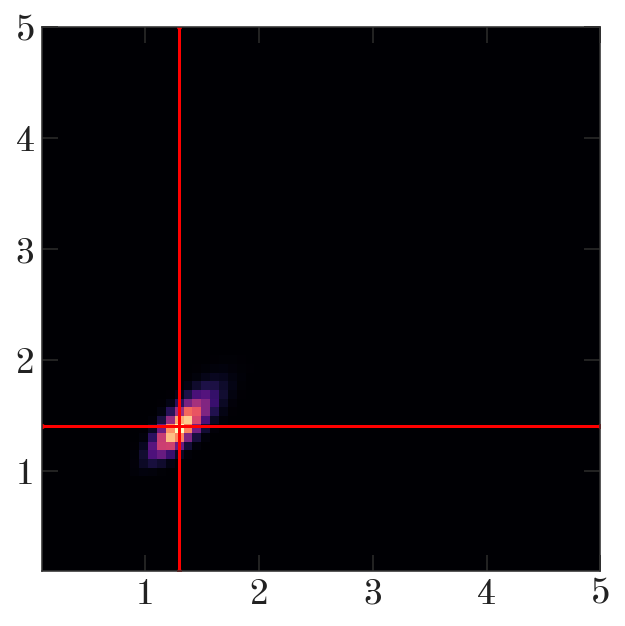

In [51]:
plt.figure(figsize=(5, 5))
plt.pcolormesh(a_b_grid[:, 0].reshape(_ngrid, _ngrid),
               a_b_grid[:, 1].reshape(_ngrid, _ngrid),
               np.exp(ll_grid))
plt.axvline(1.3, color='r')
plt.axhline(1.4, color='r')

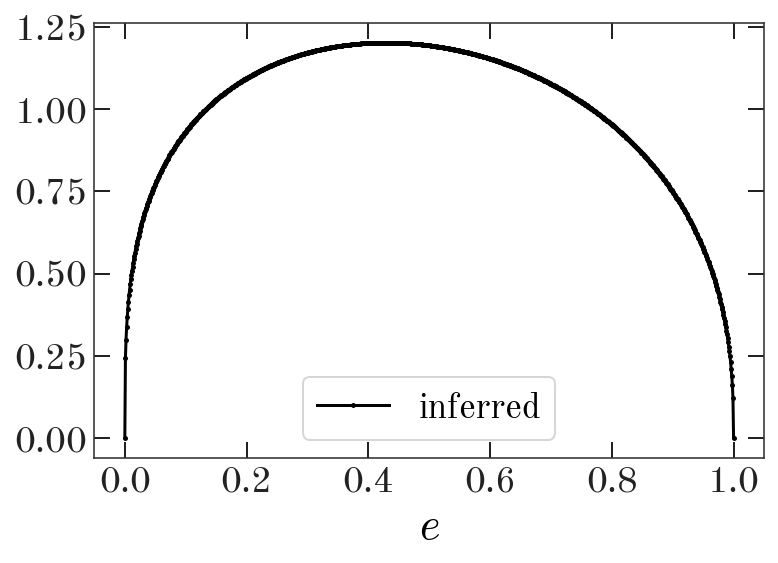

In [53]:
e_grid = np.linspace(0, 1, 1024)
# plt.plot(e_grid, np.exp(beta_logpdf(e_grid, *np.mean(sampler.chain[:, 0, :], axis=0))), label='interim')
plt.plot(e_grid, np.exp(beta_logpdf(e_grid, 1.3, 1.4)), label='inferred')
plt.xlabel('$e$')
plt.legend(fontsize=18)
plt.gcf().set_facecolor('w')

In [417]:
ln_likelihood([0.89, 3.03], *args).sum(), ln_likelihood([8.75, 3.3], *args).sum()

(0.6391238886030894, -58.49630938915412)

In [371]:
%timeit ln_prob([0.89, 3.03], *args)

1.95 ms ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [418]:
import emcee

In [419]:
sampler = emcee.EnsembleSampler(64, ndim=2, log_prob_fn=ln_prob, args=args)
p0 = emcee.utils.sample_ball([0.867, 3.03], [1e-3, 1e-3], size=sampler.nwalkers)

In [420]:
sampler.reset()
pos, *_ = sampler.run_mcmc(p0, 128, progress='notebook')
pos = emcee.utils.sample_ball(np.median(pos, axis=0), [1e-3, 1e-3], size=sampler.nwalkers)
sampler.reset()
_ = sampler.run_mcmc(pos, 128, progress='notebook')

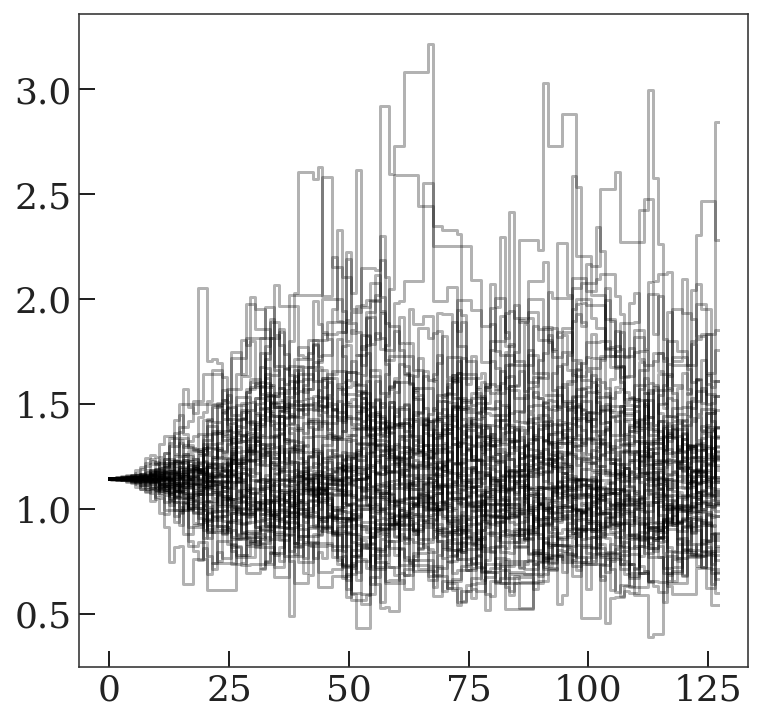

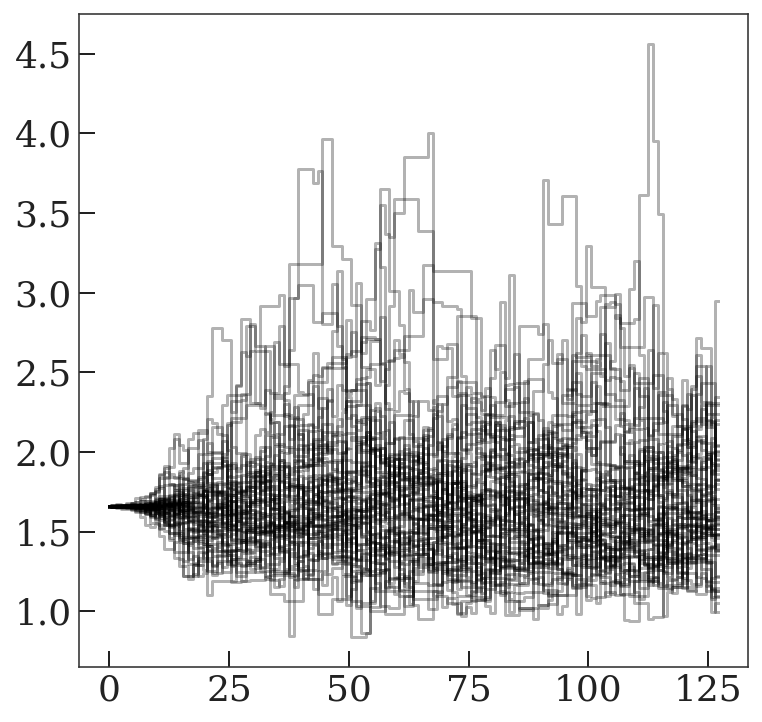

In [421]:
for k in range(sampler.ndim):
    plt.figure()
    for walker in sampler.chain[..., k]:
        plt.plot(walker, color='k', marker='', drawstyle='steps-mid', alpha=0.3)

In [422]:
# e_grid = np.linspace(0, 1, 1024)
# plt.plot(e_grid, np.exp(beta_logpdf(e_grid, *np.mean(sampler.chain[:, 0, :], axis=0))), label='interim')
# plt.plot(e_grid, np.exp(beta_logpdf(e_grid, *np.median(sampler.chain[:, -1, :], axis=0))), label='inferred')
# plt.xlabel('$e$')
# plt.legend(fontsize=18)
# plt.gcf().set_facecolor('w')

In [423]:
sampler.chain.shape

(64, 128, 2)

(-0.1, 10)

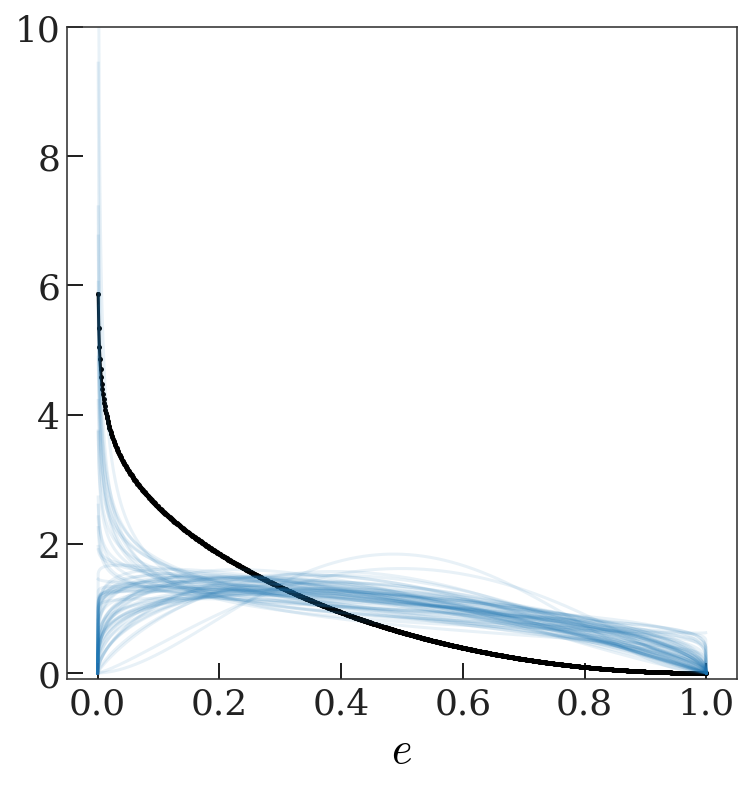

In [425]:
e_grid = np.linspace(0, 1, 1024)
plt.plot(e_grid, np.exp(beta_logpdf(e_grid, 0.867, 3.03)))

for j in range(sampler.chain.shape[0]):
    plt.plot(e_grid, np.exp(beta_logpdf(e_grid, *sampler.chain[j, -1, :])), 
             alpha=0.1, marker='', color='tab:blue')
plt.xlabel('$e$')
plt.gcf().set_facecolor('w')
plt.ylim(-0.1, 10)

---

In [486]:
import pymc3 as pm
import theano.tensor as tt
import theano
import exoplanet as xo

In [ ]:
# (e_nk[Kn_mask], K_n[Kn_mask], b_n[Kn_mask], ln_prior0[Kn_mask])

In [481]:
def logp(e, e_nk, K_n, ln_b_n, ln_p0):
    new_ln_prob = e.distribution.logp(e_nk)
    ll = pm.logsumexp(new_ln_prob - ln_p0 + ln_b_n, axis=1) - tt.log(K_n)
    return ll.sum()

In [482]:
observed = {
    'e_nk': e_nk[Kn_mask], 
    'K_n': K_n[Kn_mask],
    'ln_b_n': np.log(b_n[Kn_mask]),
    'ln_p0': ln_prior0[Kn_mask]
}

for k in observed:
    observed[k][np.isnan(observed[k])] = -9999.

In [487]:
with pm.Model() as model:
    a = pm.Uniform('a', 0.1, 10)
    b = pm.Uniform('b', 0.1, 10)
    e_n = pm.Beta('e', a, b)
    
    test = pm.DensityDist('test', logp, observed={'e': e_n , **observed})
    print(model.logp(model.test_point))
    
    # trace = pm.sample(100, tune=100, cores=1)
    trace = pm.sample(tune=2000, draws=2000, chains=2, 
                      step=xo.get_dense_nuts_step())

133.23451006350732


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [e, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [03:10<00:00, 41.96draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aae0e02ac50>,
      dtype=object)

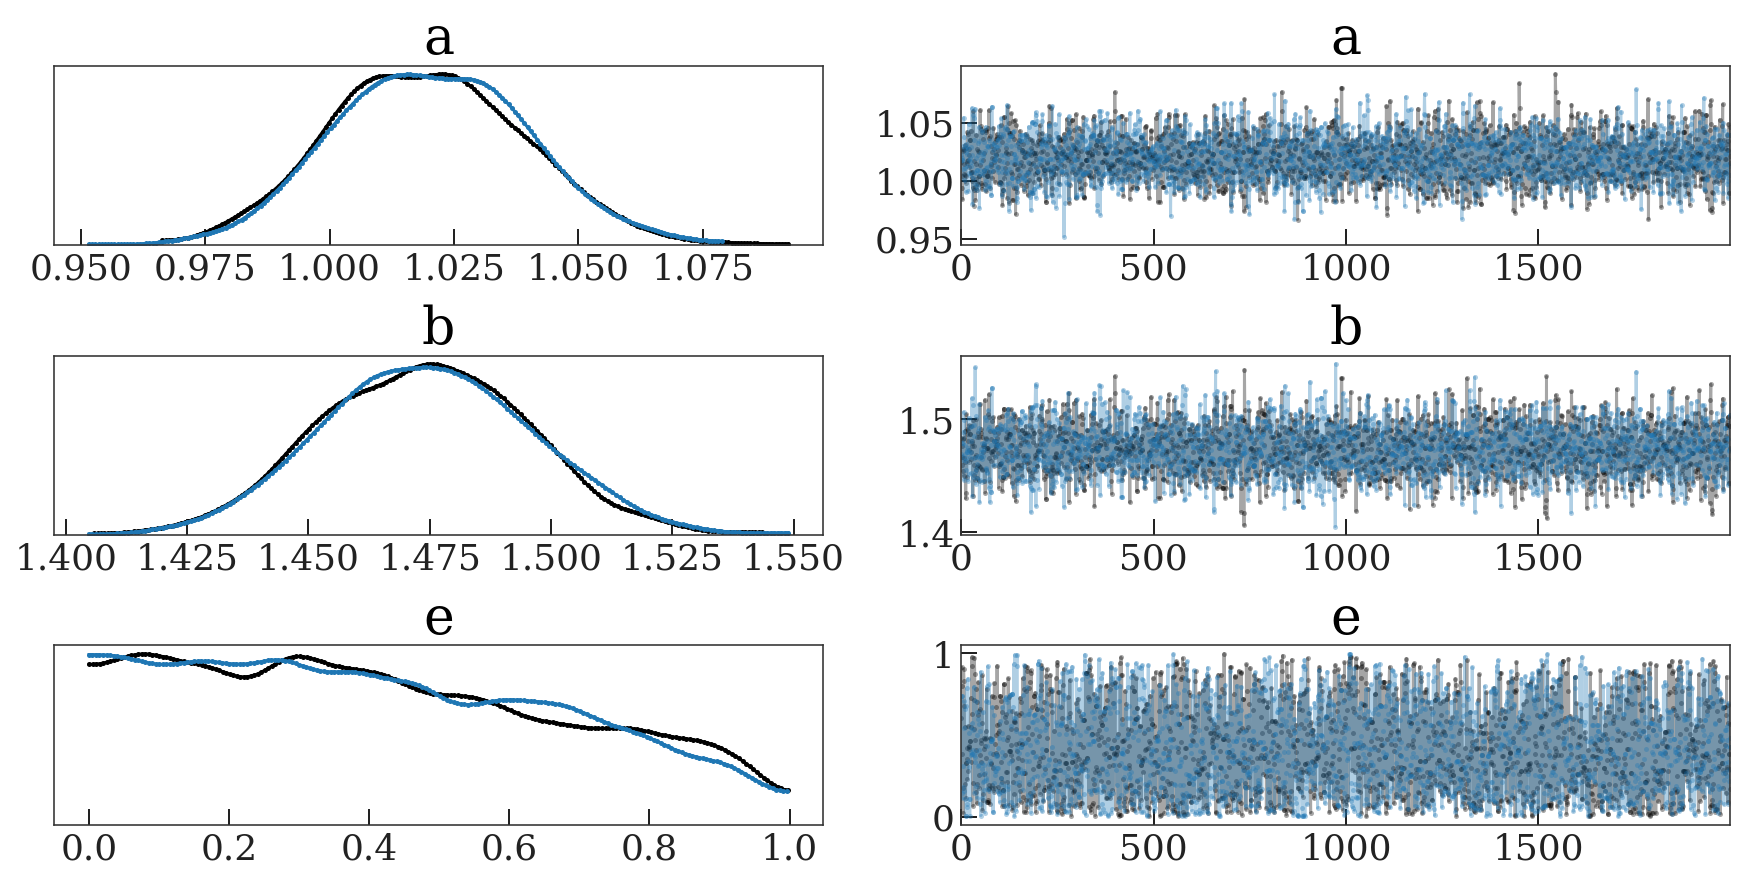

In [488]:
pm.traceplot(trace)

(-0.1, 10)

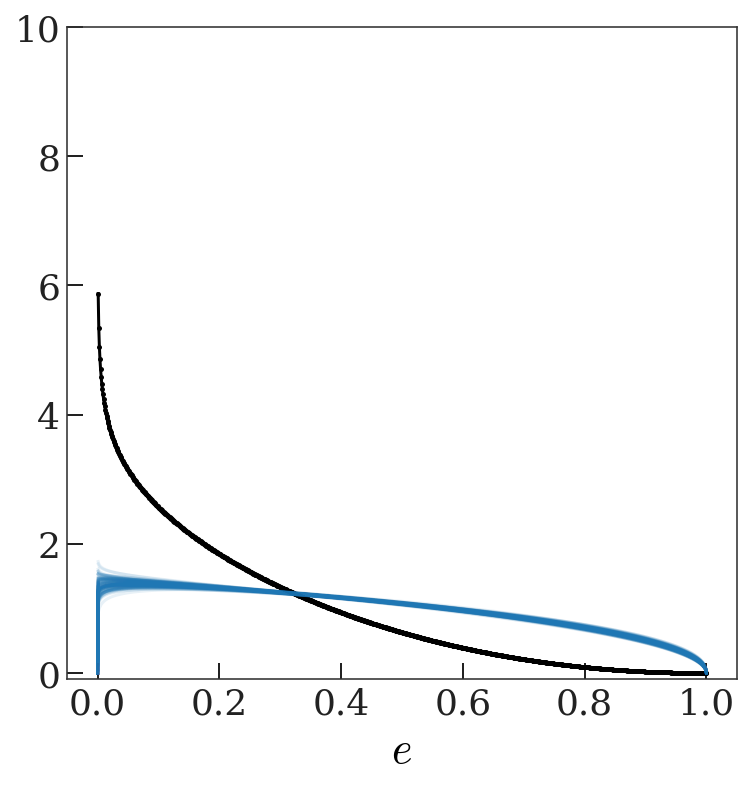

In [502]:
e_grid = np.linspace(0, 1, 1024)
plt.plot(e_grid, np.exp(beta_logpdf(e_grid, 0.867, 3.03)))

# for j in range(sampler.chain.shape[0]):
#     plt.plot(e_grid, np.exp(beta_logpdf(e_grid, *sampler.chain[j, -1, :])), 
#              alpha=0.1, marker='', color='tab:blue')

for a, b in zip(np.random.choice(trace.get_values('a', thin=10), size=128, replace=False),
                np.random.choice(trace.get_values('b', thin=10), size=128, replace=False)):
    plt.plot(e_grid, np.exp(beta_logpdf(e_grid, a, b)), 
                alpha=0.1, marker='', color='tab:blue')

plt.xlabel('$e$')
plt.gcf().set_facecolor('w')
plt.ylim(-0.1, 10)